In [1]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2

     |████████████████████████████████| 27.4 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 101 kB 3.6 MB/s 
     |████████████████████████████████| 22.3 MB 48.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but 

In [2]:
def classicSympEuler(z,f1,f2,h,maxiters):
	## classical symplectic Euler scheme
	dim = int(len(z)/2)
	q=z[:dim]
	p=z[dim:]
	fstage = lambda stg: h * f1(np.block([q + stg, p]))

	stageold=np.zeros(dim) 
	stage = fstage(stageold) +0.
	Iter = 0

	while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<int(maxiters)):
		stageold = stage+0.
		stage = fstage(stage)+0.
		Iter = Iter+1
	q = q+stage
	p = p + h*f2(np.block([q,p]))
	return np.block([q,p])

def SympEulerTrajectory(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h+1)):
      trj[:,i+1] = classicSympEuler(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]


def CreateTrainingDataTrajSympEuler(traj_len,ini_con,spacedim,h,f1,f2,seed,n_h = 800,maxiters=100):
  np.random.seed(seed = seed)
  startcon = np.random.uniform(spacedim[0][0], spacedim[0][1], size = ini_con)
  for i in range(len(spacedim)-1):
    startcon = np.vstack((startcon, np.random.uniform(spacedim[i+1][0], spacedim[i+1][1], size = ini_con)))
  h_gen = h/n_h
  finalcon = startcon.copy()
  if ini_con==1: return SympEulerTrajectory(startcon,f1,f2,h,traj_len,n_h,maxiters)
  else:
    start, final= SympEulerTrajectory(np.squeeze(startcon[:,0]),f1,f2,h,traj_len,n_h,maxiters)
    for k in range(ini_con-1):
      new_start, new_final = SympEulerTrajectory(np.squeeze(startcon[:,k+1]),f1,f2,h,traj_len,n_h,maxiters)
      start = np.hstack((start, new_start))
      final = np.hstack((final, new_final))
  return start,final



In [7]:
def iterator(fstage,dim,maxiters):
  stageold=np.zeros(dim) 
  stage = fstage(stageold) +0.
  Iter = 0
  while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<maxiters):
    stageold = stage+0.
    stage = fstage(stage)+0.
    Iter = Iter+1
  return stage

def StormerInt(z,f1,f2,h,maxiters):
	## classical symplectic Euler scheme
    dim = int(len(z)/2)
    x=z[:dim]
    y=z[dim:]
    ystage = lambda stg: h/2 * f2(np.block([x, y + stg]))
    stage=iterator(ystage,dim,maxiters)
    y=y+stage

    xstage = lambda stg: h/2 * (f1(np.block([x, y]))+f1(np.block([x+stg, y])))
    stage=iterator(xstage,dim,maxiters)
    x=x+stage
    y=y+h/2*f2(np.block([x, y]))
    return np.block([x,y])

def StormerTrajectory(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = StormerInt(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]

def CreateTrainingDataTrajStormer(traj_len,ini_con,spacedim,h,f1,f2,seed,n_h = 800):
  np.random.seed(seed = seed)
  startcon = np.random.uniform(spacedim[0][0], spacedim[0][1], size = ini_con)
  for i in range(len(spacedim)-1):
    startcon = np.vstack((startcon, np.random.uniform(spacedim[i+1][0], spacedim[i+1][1], size = ini_con)))
  h_gen = h/n_h
  finalcon = startcon.copy()
  # Compute flow map from Halton sequence to generate learning data
  if ini_con==1: return StormerTrajectory(startcon,f1,f2,h,N=traj_len)
  else:
    start, final= StormerTrajectory(np.squeeze(startcon[:,0]),f1,f2,h,N=traj_len)
    for k in range(ini_con-1):
      new_start, new_final = StormerTrajectory(np.squeeze(startcon[:,k+1]),f1,f2,h,N=traj_len)
      start = np.hstack((start, new_start))
      final = np.hstack((final, new_final))
  return start,final

In [8]:
import numpy as np
from skopt.space import Space
from skopt.sampler import Halton

a, b, g, d = 2/3, 4/3, 1., 1.
f2 = lambda z: d * z[0] * z[1] - g * z[1]
f1 = lambda x: a * x[0] - b * x[0] * x[1]
H = lambda z: d * z[0] - g * np.log(z[0]) + b * z[1] - a * np.log(z[1])
spacedim=[(0.1, 4.), (0.1, 4.)]


euler = CreateTrainingDataTrajSympEuler(1,64,spacedim,0.1,f1,f2,seed = 1,n_h = 1)
stormer = CreateTrainingDataTrajStormer(1,64,spacedim,0.1,f1,f2,seed = 1,n_h = 1)

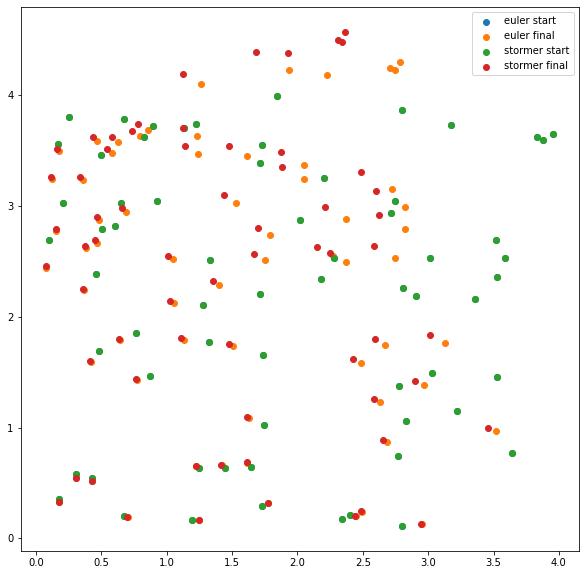

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.scatter(euler[0][0,:],euler[0][1,:], label = "euler start")
plt.scatter(euler[1][0,:],euler[1][1,:], label = "euler final")
plt.scatter(stormer[0][0,:],stormer[0][1,:], label = "stormer start")
plt.scatter(stormer[1][0,:],stormer[1][1,:], label = "stormer final")
plt.legend()

In [11]:
euler[1], stormer[1]

(array([[1.77494391, 2.37426561, 0.07775427, 1.05326709, 0.46760455,
         0.36760374, 0.58344678, 1.42187481, 1.61653294, 1.61095421,
         1.50404928, 2.68469837, 0.62797894, 3.12606886, 0.15467304,
         2.05018334, 1.22866724, 1.79302359, 0.4842432 , 0.77351352,
         2.96487335, 2.74417322, 1.13091901, 1.93322985, 2.72357116,
         2.8260722 , 0.42895518, 0.17516903, 0.64570989, 2.82561574,
         0.41725219, 1.6284569 , 2.70806561, 1.75050572, 2.95131939,
         1.04964487, 2.48750457, 2.74837287, 0.12173481, 2.67170383,
         2.788066  , 2.3747348 , 1.25011983, 2.22255042, 0.38484471,
         1.26036773, 3.51595065, 1.22310707, 0.85380686, 0.46379359,
         0.17893324, 2.05109615, 0.69123919, 0.79601892, 1.5320098 ,
         0.30467489, 2.44414636, 0.70003538, 2.4946187 , 2.63242488,
         0.35806801, 1.39773079, 2.27540964, 1.23891007],
        [0.31766527, 2.4909596 , 2.44082576, 2.1192966 , 3.58246539,
         2.23657596, 3.4723391 , 0.66298897, 

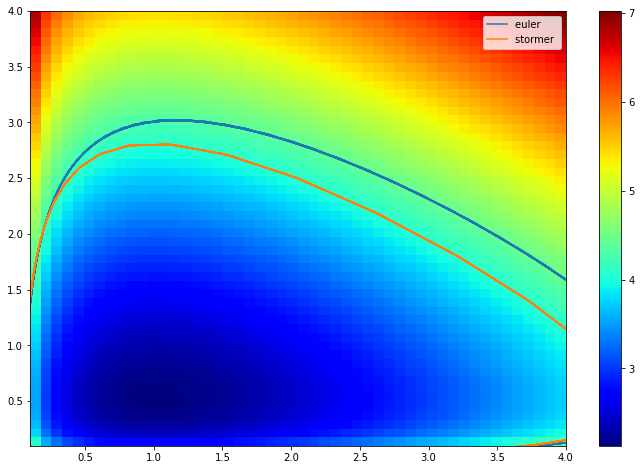

In [ ]:
from matplotlib import cm


h=0.1
euler = SympEulerTrajectory(np.asarray([0.1,0.1]),f1,f2,h,N=1000,n_h=1,maxiters=1000)
stormer = StormerTrajectory(np.asarray([0.1,0.1]),f1,f2,h,N=1000,n_h=1,maxiters=1000)

xxshort1,yyshort1 = np.linspace(spacedim[0][0], spacedim[0][1], 50), np.linspace(spacedim[1][0], spacedim[1][1], 50)
xshort1,yshort1 = np.meshgrid(xxshort1,yyshort1)

H_true = H(np.c_[np.ravel(xshort1),np.ravel(yshort1)].transpose())

plt.figure(figsize = (12,8))
plt.plot(euler[0][0],euler[0][1], label = "euler ")
plt.plot(stormer[0][0],stormer[0][1], label = "stormer ")
plt.imshow(np.flip(H_true.reshape(xshort1.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]), aspect = 'auto')
plt.colorbar()
# plt.plot(traj[0][0,:], traj[0][1,:], color = 'black')
plt.xlim(spacedim[0][0], spacedim[0][1])
plt.ylim(spacedim[1][0], spacedim[1][1])
plt.legend()

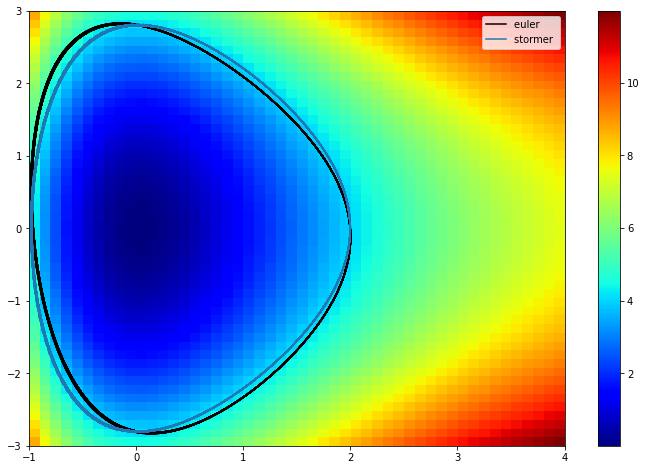

In [ ]:
f1 = lambda z: z[1]
D=10
alpha=0.5
f2 = lambda z: -2*D*alpha*(np.exp(-alpha*z[0])-np.exp(-2*alpha*z[0]))
H = lambda z: 1/2*np.asarray(z[1])**2 + D*(1-np.exp(-alpha*z[0]))**2
spacedim=[(-1., 4.), (-3.0, 3.0)]

h=0.1
euler = SympEulerTrajectory(np.asarray([2.,0.]),f1,f2,h,N=1000,n_h=1,maxiters=1000)
stormer = StormerTrajectory(np.asarray([2.,0.]),f1,f2,h,N=1000,n_h=1,maxiters=1000)

xxshort1,yyshort1 = np.linspace(spacedim[0][0], spacedim[0][1], 50), np.linspace(spacedim[1][0], spacedim[1][1], 50)
xshort1,yshort1 = np.meshgrid(xxshort1,yyshort1)

H_true = H(np.c_[np.ravel(xshort1),np.ravel(yshort1)].transpose())

plt.figure(figsize = (12,8))
plt.plot(euler[0][0],euler[0][1], label = "euler ", color = 'black')
plt.plot(stormer[0][0],stormer[0][1], label = "stormer ")
plt.imshow(np.flip(H_true.reshape(xshort1.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]), aspect = 'auto')
plt.colorbar()
# plt.plot(traj[0][0,:], traj[0][1,:], color = 'black')
plt.xlim(spacedim[0][0], spacedim[0][1])
plt.ylim(spacedim[1][0], spacedim[1][1])
plt.legend()